### P3 Flow Setup

## read CSV

In [1]:
import random
import csv
import cv2
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dropout, ELU
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.core import Lambda, Dense, Activation, Flatten
import matplotlib.pyplot as plt
from collections import Counter

CSV_PATH_LIST = ["./train_data_0/driving_log.csv"]
IMG_PATH_PREFIX = "./train_data/"




Using TensorFlow backend.


total sample count before cleaning:  8036
most common steering angles: [(0.0, 4361), (0.1765823, 237), (-0.1452064, 179), (0.0904655, 165), (-0.05975719, 152), (-0.0787459, 150), (0.1670138, 136), (-0.06925154, 129), (0.04262284, 106), (0.1287396, 98)]


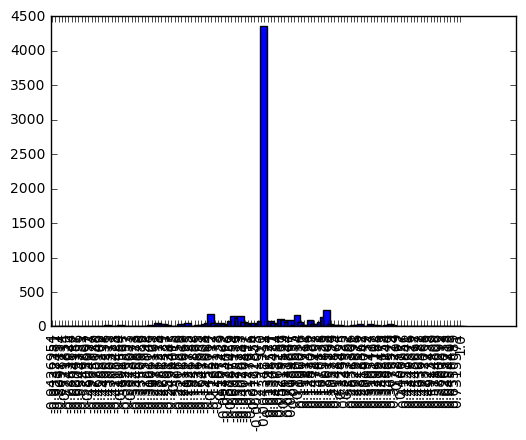

most common steering angles after cleaning: [(' 0', 491), (' 0.1765823', 237), (' -0.1452064', 179), (' 0.0904655', 165), (' -0.05975719', 152), (' -0.0787459', 150), (' 0.1670138', 136), (' -0.06925154', 129), (' 0.04262284', 106), (' 0.1287396', 98)]


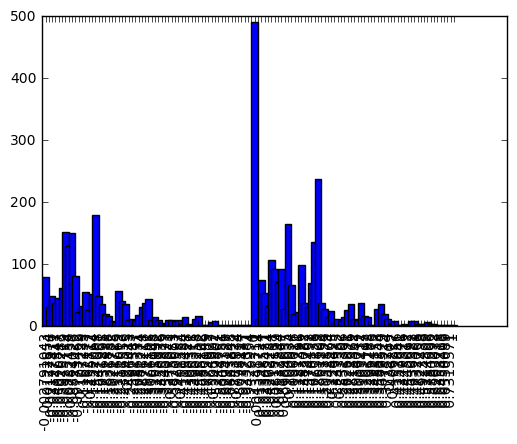

total sample count after cleaning:  4166


In [2]:
'''
CSV file format
center,left,right,steering,throttle,brake,speed
IMG/center_2016_12_01_13_30_48_287.jpg, IMG/left_2016_12_01_13_30_48_287.jpg, IMG/right_2016_12_01_13_30_48_287.jpg, 0, 0, 0, 22.14829
IMG/center_2016_12_01_13_30_48_404.jpg, IMG/left_2016_12_01_13_30_48_404.jpg, IMG/right_2016_12_01_13_30_48_404.jpg, 0, 0, 0, 21.87963
'''

def data_preprocessing(csv_path_list):
    sample_line_list = []
    counter = Counter()
    
    for csv_path in csv_path_list:
        with open(csv_path) as csvfile:
            next(csvfile, None) ## skip the header
            reader = csv.reader(csvfile)
            for line in reader:
                sample_line_list.append(line)
                counter[float(line[3])] += 1    
    
    keys = sorted(counter.keys())
    print("total sample count before cleaning: ", len(sample_line_list))
    
    most_common_angles = counter.most_common(10)
    print("most common steering angles:",most_common_angles)
    indexes = np.arange(len(keys)) 
    angle_count = [counter[k] for k in keys]
    
    plt.bar(indexes, angle_count, width=2)
    plt.xticks(indexes + 0.5 * 0.5, keys, rotation=90)
    plt.show()
    
    
    clean_counter = Counter()
    final_sample_list = []
    
    for sample in sample_line_list:
        if abs(float(sample[3]) - 0.00) < 0.001: #angle = 0.0
            if random.random() <= most_common_angles[1][1]/most_common_angles[0][1] * 2:
                final_sample_list.append(sample)
                clean_counter[sample[3]] += 1
        else:
            final_sample_list.append(sample)
            clean_counter[sample[3]] += 1
    
    
    print("most common steering angles after cleaning:", clean_counter.most_common(10))
    clean_keys = sorted(clean_counter.keys())
    clean_indexes = np.arange(len(clean_keys)) 
    clean_angle_count = [clean_counter[k] for k in clean_keys]
    
    plt.bar(clean_indexes, clean_angle_count, width=2)
    plt.xticks(clean_indexes + 2 * 0.5, clean_keys, rotation=90)
    plt.show()
    
    print("total sample count after cleaning: ", len(final_sample_list))
    return final_sample_list
    

    
data_dict = data_preprocessing(CSV_PATH_LIST)

total sample count before cleaning:  8036
most common steering angles: [(0.0, 4361), (0.1765823, 237), (-0.1452064, 179), (0.0904655, 165), (-0.05975719, 152), (-0.0787459, 150), (0.1670138, 136), (-0.06925154, 129), (0.04262284, 106), (0.1287396, 98)]


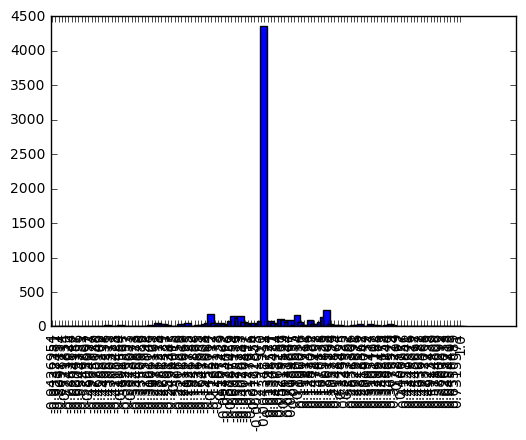

most common steering angles after cleaning: [(' 0', 464), (' 0.1765823', 237), (' -0.1452064', 179), (' 0.0904655', 165), (' -0.05975719', 152), (' -0.0787459', 150), (' 0.1670138', 136), (' -0.06925154', 129), (' 0.04262284', 106), (' 0.1287396', 98)]


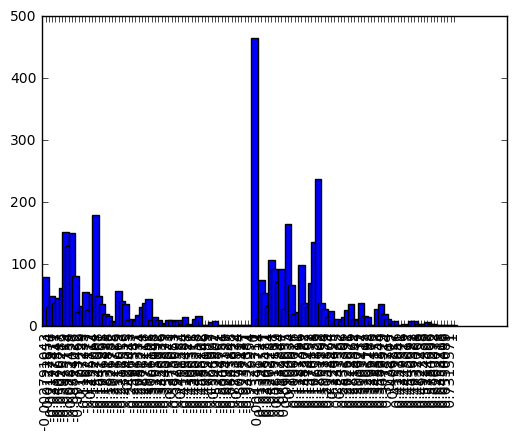

total sample count after cleaning:  4139
[array([[[[180, 144, 114],
         [180, 144, 114],
         [180, 144, 114],
         ..., 
         [181, 141, 112],
         [181, 141, 112],
         [181, 141, 112]],

        [[182, 144, 114],
         [182, 144, 114],
         [182, 144, 114],
         ..., 
         [181, 141, 112],
         [181, 141, 112],
         [181, 141, 112]],

        [[184, 144, 115],
         [184, 144, 115],
         [184, 144, 115],
         ..., 
         [182, 142, 113],
         [182, 142, 113],
         [182, 142, 113]],

        ..., 
        [[ 69,  84, 100],
         [ 72,  87, 103],
         [ 76,  91, 107],
         ..., 
         [104, 113, 126],
         [ 98, 109, 123],
         [ 96, 107, 121]],

        [[ 82,  97, 113],
         [ 72,  87, 103],
         [ 64,  79,  95],
         ..., 
         [104, 113, 123],
         [103, 112, 125],
         [106, 115, 128]],

        [[ 70,  85, 101],
         [ 67,  82,  98],
         [ 71,  86, 102],
 

In [3]:
def generator(samples, batch_size=1000):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0].split('/')[-1]
                
                name = r"C:\Localdata\data\behavioralclone\train_data_0\IMG\\" + name
                #print(name)
                
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])        

                #print(center_image)
                
                images.append(center_image)
                angles.append(center_angle)
                
                #flipping images And steering to avoid bias 
                flipped_center_image = np.fliplr(center_image)
                flipped_center_angle = -center_angle
                
                images.append(flipped_center_image)
                angles.append(flipped_center_angle)
                
                
                '''
                if center_angle != 0:
                    fig, ax = plt.subplots(nrows=2,ncols=1)
                    ax[0].imshow(center_image)
                    ax[0].set_title(str(center_angle))                
                    
                    ax[1].imshow(flipped_center_image)
                    ax[1].set_title(str(flipped_center_angle))
                    
                    plt.show()
                '''
                
                
            X_train = np.array(images)
            y_train = np.array(angles)

            yield shuffle(X_train, y_train)

            
print(next(generator(data_preprocessing(CSV_PATH_LIST))))        

In [4]:


image_color_channel = 3
image_height = 160
image_width = 320


def model_setup():
    
    model = Sequential()

    #cropping layer
    crop_top = 70
    crop_bottom = 20
    crop_left = 30
    crop_right = 30
    
    '''
    model.add(Cropping2D(cropping=((crop_top,crop_bottom), (crop_left,crop_right)), input_shape=(160,320,3),  dim_ordering='tf'))
    
    #lambda layer: to normalize images to [-0.5, +0.5] 
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    
    
    #conv layer
    n_filters = 128
    model.add(Convolution2D(n_filters, 3, 3, border_mode = "valid"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
    #relu
    model.add(ELU())
    
    #conv layer
    model.add(Convolution2D(100, 3, 3, border_mode = "valid"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
    #relu
    model.add(ELU())
    
    
    #conv layer
    model.add(Convolution2D(64, 5, 5, border_mode = "same"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
    #relu
    model.add(ELU()) 
    
    #conv layer
    model.add(Convolution2D(32, 5, 5, border_mode = "valid"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
   
    model.add(ELU())
    
    # flatten()
    model.add(Flatten())
    
    
    #model.add(Dense(512))
    model.add(Dense(128))
    #drop out
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Dense(8))
    #output
    model.add(Dense(1))
    
    '''
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Dense(50))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Dense(10))
    model.add(Dense(1))
    
    return model



total sample count before cleaning:  8036
most common steering angles: [(0.0, 4361), (0.1765823, 237), (-0.1452064, 179), (0.0904655, 165), (-0.05975719, 152), (-0.0787459, 150), (0.1670138, 136), (-0.06925154, 129), (0.04262284, 106), (0.1287396, 98)]


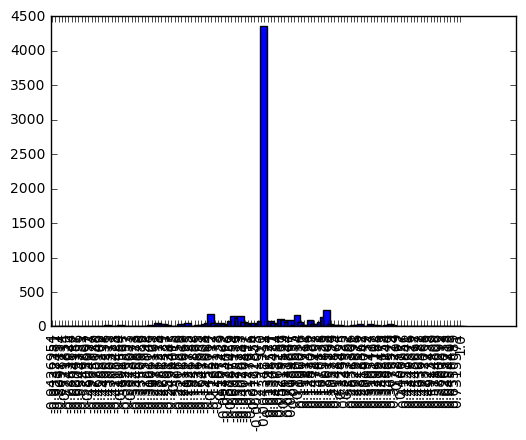

most common steering angles after cleaning: [(' 0', 470), (' 0.1765823', 237), (' -0.1452064', 179), (' 0.0904655', 165), (' -0.05975719', 152), (' -0.0787459', 150), (' 0.1670138', 136), (' -0.06925154', 129), (' 0.04262284', 106), (' 0.1287396', 98)]


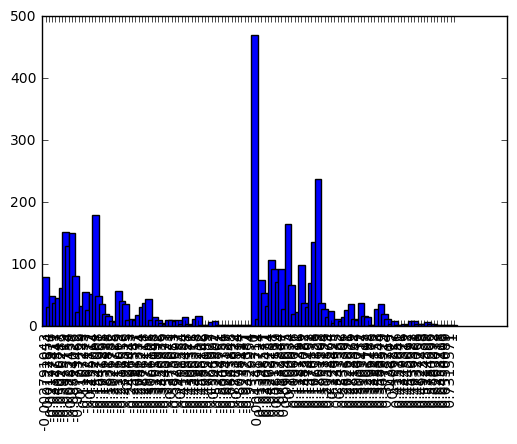

total sample count after cleaning:  4145
total sample count: 4145
train sample count:  2652 
validation sample count:  664 
test sample count:  829
sample data example ['IMG/center_2016_12_01_13_41_55_596.jpg', ' IMG/left_2016_12_01_13_41_55_596.jpg', ' IMG/right_2016_12_01_13_41_55_596.jpg', ' 0', ' 0.9855326', ' 0', ' 30.07295']
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 158, 24)   1824  

C:\Localdata\software\Anaconda2\envs\py3\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2688/2652 [==============================] - 58s - loss: 0.0468 - val_loss: 0.0260
Epoch 2/3
2680/2652 [==============================] - 55s - loss: 0.0333 - val_loss: 0.0190
Epoch 3/3
2688/2652 [==============================] - 52s - loss: 0.0218 - val_loss: 0.0200
0.0216906733112


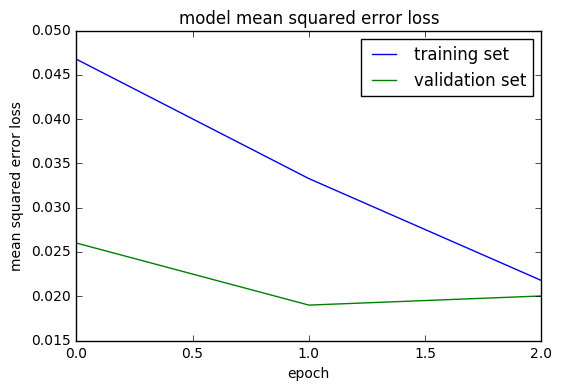

job finished. model saved


In [5]:
def flow_setup():
    
    samples = data_preprocessing(CSV_PATH_LIST)
    print("total sample count:", len(samples))
    train_validation_samples, test_samples = train_test_split(samples, test_size = 0.2, random_state = 42)
    train_samples, validation_samples = train_test_split(train_validation_samples, test_size = 0.2, random_state = 42)
    print("train sample count: ", len(train_samples), "\nvalidation sample count: ", len(validation_samples), "\ntest sample count: ", len(test_samples))
    print("sample data example", train_samples[random.randint(0, len(train_samples))])
    
    train_generator = generator(train_samples, batch_size = 32)
    validation_generator = generator(validation_samples, batch_size = 32)
    test_generator = generator(test_samples, batch_size = 32)            
    #print("generator output example: \n", next(train_generator))
    
    model = model_setup()
    model.compile(loss = "mse", optimizer="adam")
    print(model.summary())
    
    history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)
    score = model.evaluate_generator(test_generator, 1500, max_q_size=10, nb_worker=1, pickle_safe=False)
    print(score)
    
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    
    
    model.save('model.h5')
    print("job finished. model saved")
    
flow_setup()